# Módulo 5 Evaluación de un modelo y su aplicación para predicción

Autor: Ricardo Ramírez Condado - A01379299

## Preprocesamiento y análisis de datos multivariados o series temporales.

El siguiente notebook mostrará un análisis de serie temporal que posiblemente contenga tendencias y patrones estacionales sobre el tráfico de distintas páginas web a lo largo del tiempo, lo que permitirá analizar tendencias y patrones en el uso de internet.

## Paso 1: Preparación del Entorno y Carga de Datos

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# Carga de datos
df = pd.read_csv('train_1.csv')
# Mostrar las primeras filas para entender la estructura del DataFrame
print(df.head())

                                                Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  

## Paso 2: Transformación del DataFrame

In [3]:
# Reemplazamos los valores NaN por 0 para simplificar el ejemplo
df.fillna(0, inplace=True)
# "Derrite" el DataFrame para convertir las columnas de fechas en una sola columna 'fecha' con los valores correspondientes
df_melted = df.melt(id_vars=['Page'], var_name='fecha', value_name='visitas')

# Convierte la columna 'fecha' a un tipo de dato datetime
df_melted['fecha'] = pd.to_datetime(df_melted['fecha'])

# Establece las columnas 'fecha' y 'Page' como índice para un fácil acceso
df_melted.set_index(['fecha', 'Page'], inplace=True)

print(df_melted.head())

                                                               visitas
fecha      Page                                                       
2015-07-01 2NE1_zh.wikipedia.org_all-access_spider                18.0
           2PM_zh.wikipedia.org_all-access_spider                 11.0
           3C_zh.wikipedia.org_all-access_spider                   1.0
           4minute_zh.wikipedia.org_all-access_spider             35.0
           52_Hz_I_Love_You_zh.wikipedia.org_all-access_sp...      0.0


## Paso 3: Análisis Exploratorio Inicial
Después de transformar tus datos, es útil hacer un análisis exploratorio inicial:

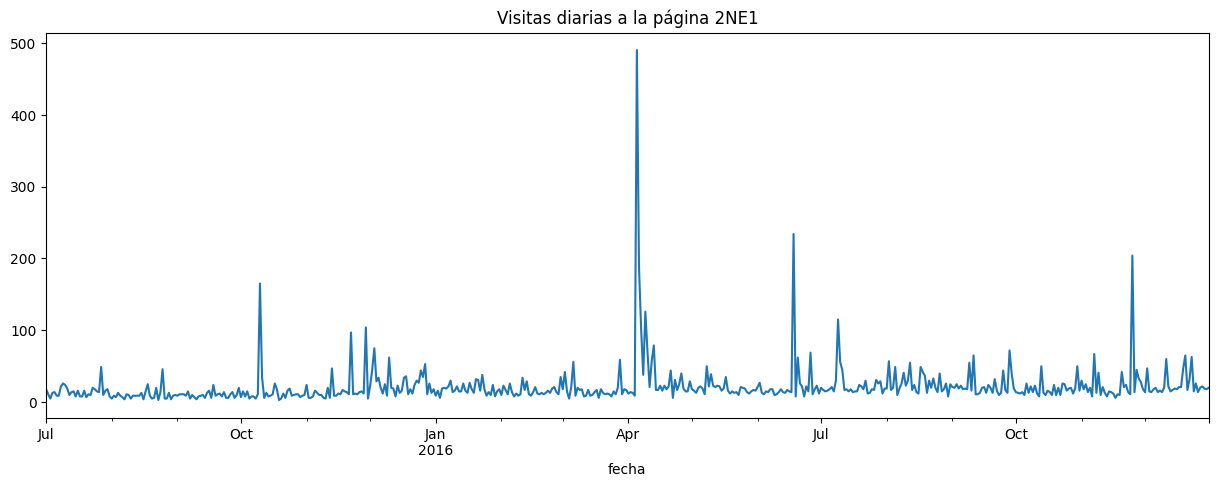

Estadístico ADF: -8.884037701518485
p-valor: 1.294670409024795e-14


In [4]:
# Selecciona una página de interés, por ejemplo la primera, y realiza un análisis exploratorio
page_visits = df_melted.xs('2NE1_zh.wikipedia.org_all-access_spider', level='Page')

# Visualización de los datos de visitas de la página seleccionada
page_visits['visitas'].plot(figsize=(15,5), title='Visitas diarias a la página 2NE1')
plt.show()

# Realiza una prueba de Dickey-Fuller para comprobar si la serie temporal es estacionaria
resultado_adfuller = adfuller(page_visits['visitas'].dropna())
print(f'Estadístico ADF: {resultado_adfuller[0]}')
print(f'p-valor: {resultado_adfuller[1]}')

## Paso 4: Preparación para Modelado ARIMA
A continuación, se dividirá la serie temporal en un conjunto de entrenamiento y uno de prueba para preparar para el modelado:

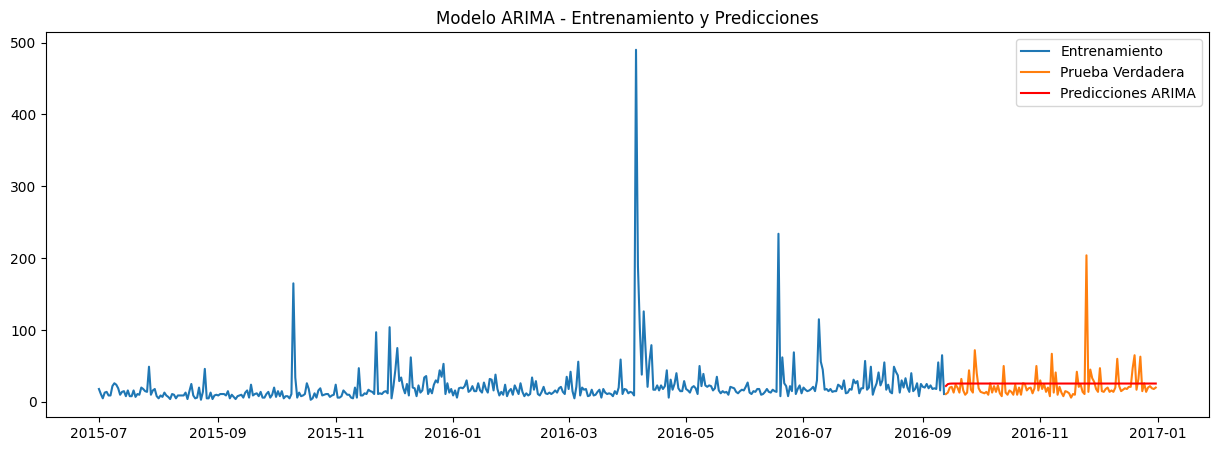

In [5]:
# Dividir los datos en conjunto de entrenamiento y prueba
train = page_visits['visitas'][:int(0.8*len(page_visits))]
test = page_visits['visitas'][int(0.8*len(page_visits)):]

# Ajustar el modelo ARIMA. Asegúrate de utilizar los parámetros adecuados basados en tu análisis anterior.
# Por ahora, usaremos parámetros (1,1,1).
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

# Realizar predicciones
predictions = model_fit.forecast(steps=len(test))

# Visualizar las predicciones en comparación con los datos reales de prueba
plt.figure(figsize=(15,5))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Prueba Verdadera')
plt.plot(test.index, predictions, label='Predicciones ARIMA', color='red')
plt.legend()
plt.title('Modelo ARIMA - Entrenamiento y Predicciones')
plt.show()

## Paso 5: Evaluación del Modelo

In [6]:
# Evaluar el modelo utilizando métricas como MSE y RMSE
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MSE: 486.13829970481527
RMSE: 22.04854416293319


## Paso 6: Transformación de los Datos en Serie Temporal Larga

In [7]:
# Transformación de los datos
df_melted = df.melt(id_vars=['Page'], var_name='fecha', value_name='visitas')
df_melted['fecha'] = pd.to_datetime(df_melted['fecha'])

# Queremos analizar la serie temporal de una página en particular
pagina_ejemplo = '2NE1_zh.wikipedia.org_all-access_spider'
df_pagina = df_melted[df_melted['Page'] == pagina_ejemplo].set_index('fecha')

## Paso 7: Análisis de Tendencia y Estacionalidad

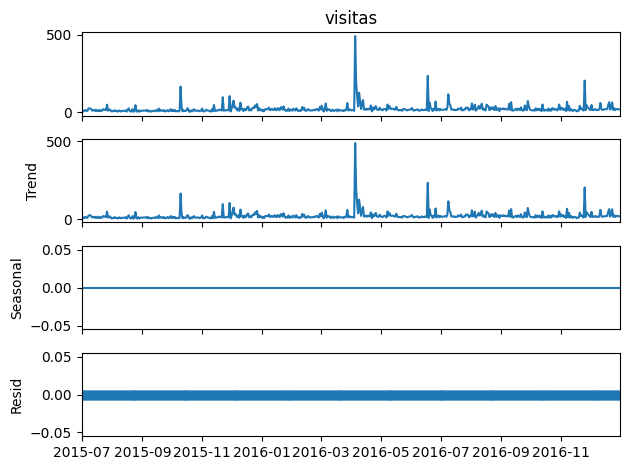

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# La frecuencia es 1 si tus datos son diarios y no tienes un año completo de datos
descomposicion = seasonal_decompose(df_pagina['visitas'], model='additive', period=1)

# Graficar la descomposición
descomposicion.plot()
plt.show()

## Paso 8: Prueba de Dickey-Fuller para Estacionariedad

In [9]:
# Realizar la prueba de Dickey-Fuller aumentada para evaluar la estacionariedad
adf_test = adfuller(df_pagina['visitas'].dropna())

# Imprimir los resultados
print(f'Estadístico ADF: {adf_test[0]}')
print(f'p-valor: {adf_test[1]}')

Estadístico ADF: -8.884037701518485
p-valor: 1.294670409024795e-14


## Paso 9: Análisis de Homocedasticidad

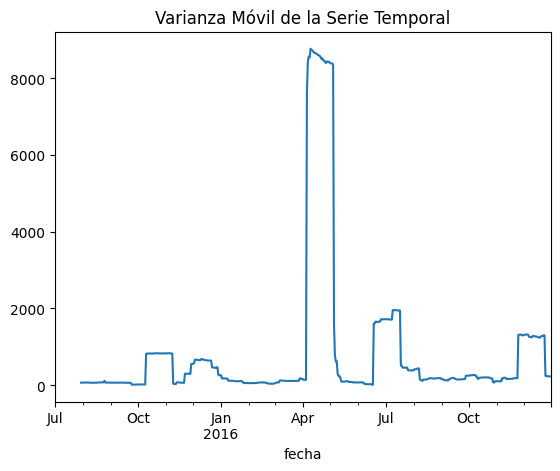

In [10]:
# Calcular y graficar la varianza móvil
rolling_var = df_pagina['visitas'].rolling(window=30).var()  # window puede ser ajustado
rolling_var.plot(title='Varianza Móvil de la Serie Temporal')
plt.show()

## Paso 10: Análisis de ACF y PACF para Parámetros ARIMA

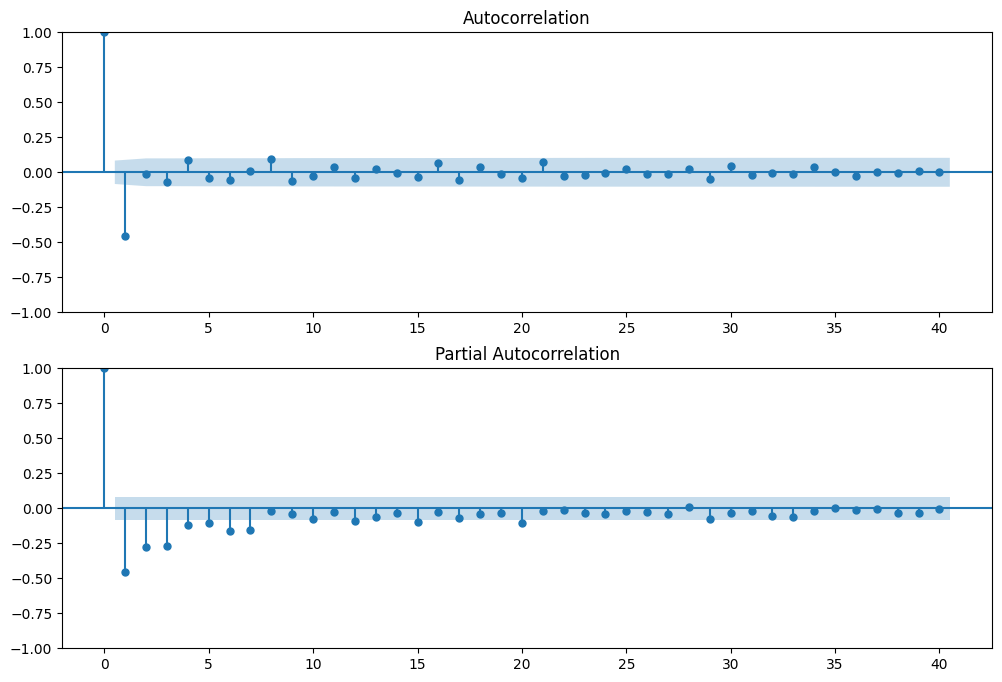

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Diferenciar la serie si no es estacionaria
df_pagina_differenced = df_pagina['visitas'].diff().dropna()

# Graficar ACF y PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_pagina_differenced, ax=ax1, lags=40)  # Ajusta los lags según sea necesario
plot_pacf(df_pagina_differenced, ax=ax2, lags=40)
plt.show()

## Paso 11: Propuesta y Ajuste del Modelo ARIMA

In [12]:
# Definir los parámetros del modelo ARIMA
p = 1  # El primer lag en PACF es significativo, sugiriendo un término AR de 1
d = 1  # La serie necesita ser diferenciada una vez
q = 0  # No hay picos significativos en ACF después del lag inicial, sugiriendo no usar términos MA

# Ya que se ha determinado los parámetros p, d, y q
model = ARIMA(df_pagina['visitas'], order=(p,d,q))  # Reemplaza p, d, y q con los valores apropiados
model_fit = model.fit()

# Predicciones
df_pagina['predicciones'] = model_fit.predict(start=df_pagina.index[0], end=df_pagina.index[-1])

In [13]:
df_pagina['predicciones'] = model_fit.predict(start=0, end=len(df_pagina) - 1)

### Predicciones futuras:

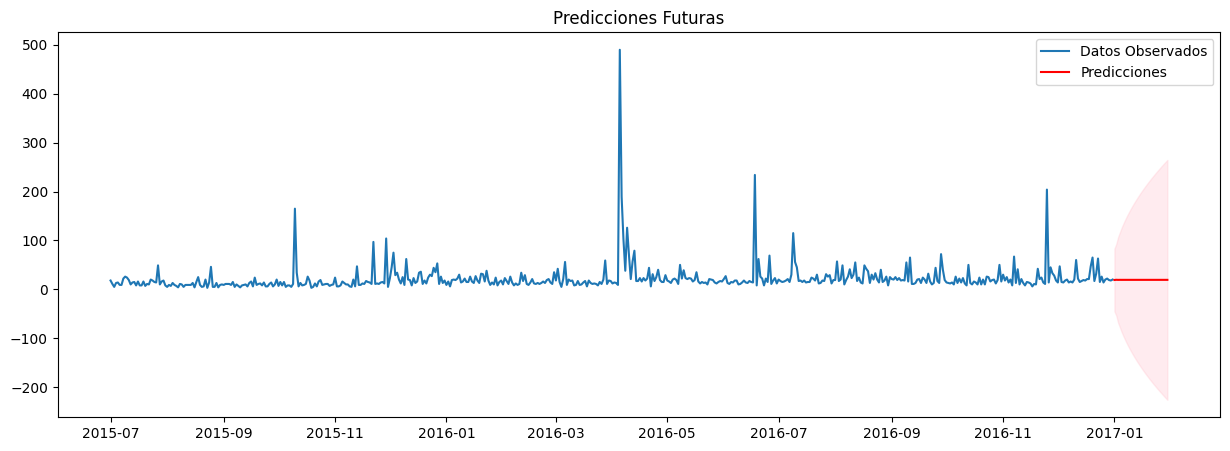

In [14]:
# Suponiendo que 'model_fit' es el modelo ajustado con los datos de entrenamiento
num_steps = 30  # Reemplaza con la cantidad de días que quieres predecir
pred_start_date = df_pagina.index[-1] + pd.Timedelta(days=1)
pred_end_date = df_pagina.index[-1] + pd.Timedelta(days=num_steps)

# Realizar predicciones fuera de la muestra
predictions = model_fit.get_forecast(steps=num_steps)
predicted_means = predictions.predicted_mean
predicted_conf_int = predictions.conf_int()

# Generar índices de fecha para las predicciones
prediction_dates = pd.date_range(start=pred_start_date, periods=num_steps)

# Graficar las predicciones
plt.figure(figsize=(15, 5))
plt.plot(df_pagina.index, df_pagina['visitas'], label='Datos Observados')
plt.plot(prediction_dates, predicted_means, label='Predicciones', color='red')
plt.fill_between(prediction_dates, predicted_conf_int.iloc[:, 0], predicted_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Predicciones Futuras')
plt.show()

## Propuesta del Modelo ARIMA

Basado en el análisis de las gráficas de ACF y PACF, así como en los resultados de la prueba de Dickey-Fuller aumentada, proponemos un modelo ARIMA(1,1,0) para nuestra serie temporal de visitas a las páginas de Wikipedia. Este modelo ha sido elegido considerando la necesidad de una diferenciación para alcanzar la estacionariedad, y el corte significativo después del primer lag en la gráfica PACF.

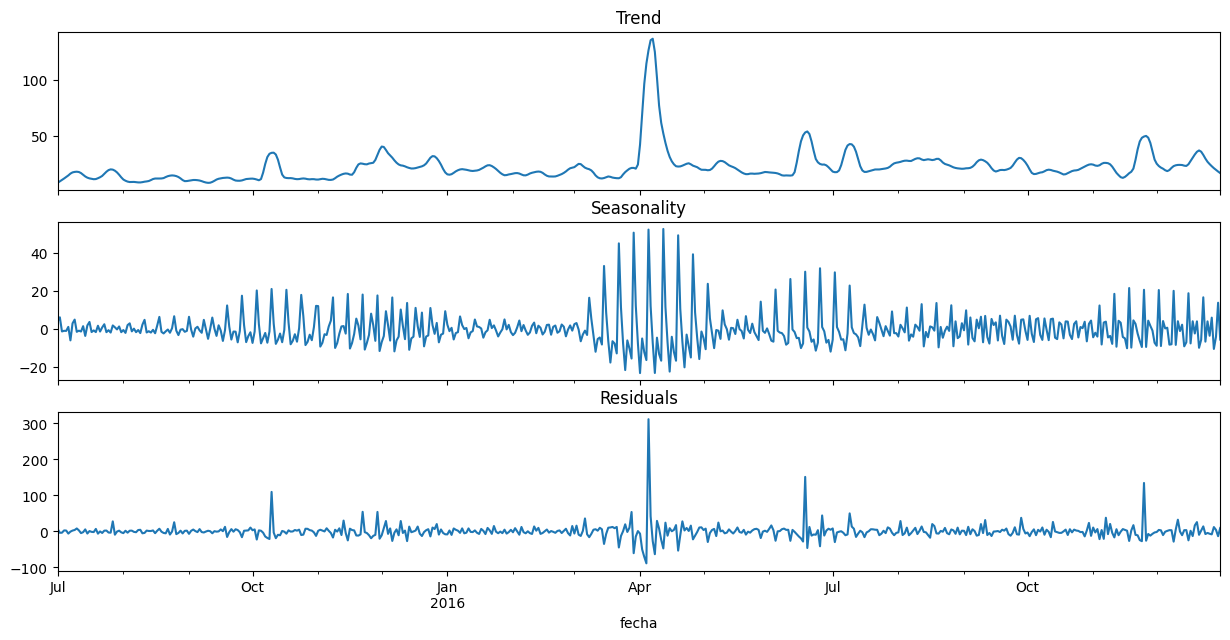

In [15]:
# Análisis de Estacionalidad
from statsmodels.tsa.seasonal import STL

stl = STL(page_visits['visitas'], seasonal=13)  # Ajusta el parámetro 'seasonal' si es necesario
result = stl.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid

# Visualización de la descomposición STL
fig, ax = plt.subplots(3,1, figsize=(15,7), sharex=True)
trend.plot(ax=ax[0], title='Trend')
seasonal.plot(ax=ax[1], title='Seasonality')
resid.plot(ax=ax[2], title='Residuals')
plt.show()

Basado en la descomposición STL de la serie temporal, hemos identificado componentes de tendencia y estacionalidad, aunque la última no es fuertemente regular. Sin embargo, para asegurarnos de capturar cualquier patrón cíclico subyacente que podría influir en las visitas a la página, proponemos utilizar un modelo SARIMA que incluya términos estacionales. 

La elección de un modelo SARIMA también está respaldada por la presencia de picos en la gráfica de residuos, lo que indica que puede haber factores estacionales específicos o eventos que causen fluctuaciones irregulares en las visitas. Incluir términos estacionales en el modelo nos permite ajustar y predecir estos patrones de manera más efectiva que con un modelo ARIMA simple.

Proponemos inicialmente un modelo SARIMA(1,1,1)(1,1,1)[S], donde 'S' será determinado basado en un análisis más detallado de la estacionalidad. El gráfico ACF indica un decaimiento lento, lo que sugiere la presencia de estacionalidad, y el gráfico PACF muestra un corte claro después del primer lag, lo que respalda un término AR de 1. Adicionalmente, la necesidad de diferenciación es sugerida por la presencia de una tendencia y por la mejora en la estacionariedad después de aplicar una primera diferenciación, lo que justifica el parámetro 'd=1'.

Avanzaremos con un análisis más detallado para optimizar los parámetros y verificar la presencia de estacionalidad más definida, lo que podría ajustar el parámetro 'S' y los términos estacionales del modelo SARIMA. Este enfoque nos permite ser flexibles y ajustar el modelo a la estructura específica de nuestros datos de serie temporal.

Tendencia: La gráfica de tendencia muestra variaciones a largo plazo en los datos, con picos ocasionales que pueden representar eventos atípicos o cambios súbitos en el comportamiento de la serie temporal. Esta tendencia podría indicar que hay factores subyacentes que afectan las visitas a lo largo del tiempo, lo que justificaría un término de diferenciación en el modelo SARIMA para estabilizar la media de la serie temporal.

Estacionalidad: Se observa una estacionalidad en la gráfica, aunque no es muy pronunciada y no sigue un patrón regular y predecible. Esto podría ser una indicación de que, aunque no hay una estacionalidad clara y fuerte, hay patrones periódicos que podrían ser capturados por los términos estacionales del modelo SARIMA.

Residuos: Los residuos parecen ser bastante consistentes a lo largo del tiempo, con algunos picos que podrían ser outliers o eventos no capturados por la tendencia y la estacionalidad. La relativa uniformidad de los residuos sugiere que el modelo de descomposición ha capturado la mayoría de las estructuras de la serie temporal, y que un modelo SARIMA podría ser adecuado para modelar la autocorrelación remanente.

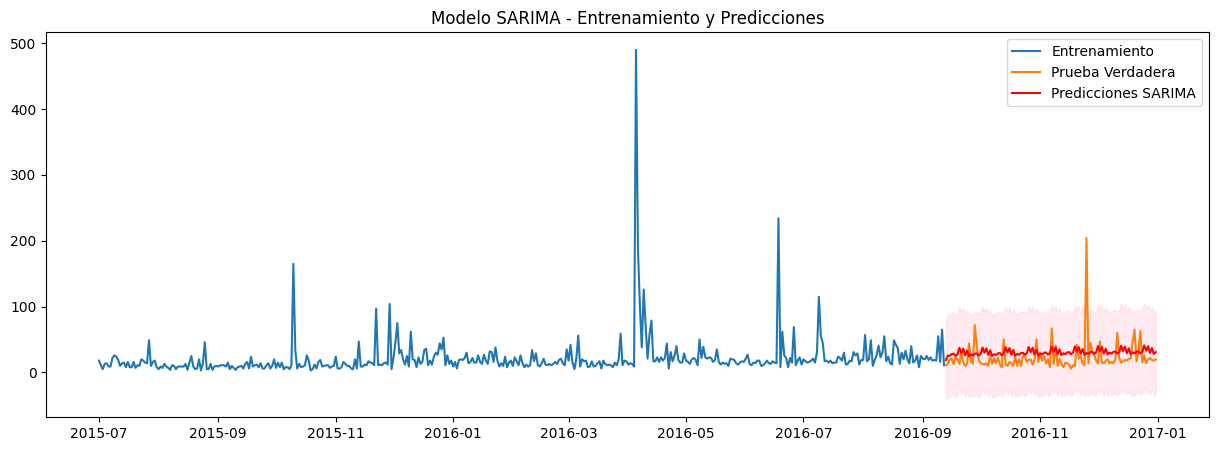

MSE: 558.9617978084036
RMSE: 23.642372930998352


In [16]:
# Selección de parámetros SARIMA basada en análisis previos y descomposición STL
p = 1  # Basado en PACF: el primer lag es significativo
d = 1  # Basado en la necesidad de diferenciación para estabilizar la tendencia
q = 1  # Basado en ACF: el primer lag es significativo
P = 1  # Estacionalidad observada en la descomposición STL
D = 1  # Presencia de tendencia estacional
Q = 1  # Estacionalidad observada en la descomposición STL
S = 12  # Suponiendo estacionalidad mensual en datos anuales

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar el modelo SARIMA
model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,S), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)  # 'disp=False' para no imprimir la salida del ajuste del modelo

# Realizar predicciones
predictions = model_fit.get_forecast(steps=len(test))
predicted_means = predictions.predicted_mean
predicted_conf_int = predictions.conf_int()

# Visualizar las predicciones en comparación con los datos reales de prueba
plt.figure(figsize=(15,5))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Prueba Verdadera')
plt.plot(test.index, predicted_means, label='Predicciones SARIMA', color='red')
plt.fill_between(test.index, predicted_conf_int.iloc[:, 0], predicted_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Modelo SARIMA - Entrenamiento y Predicciones')
plt.show()

# Evaluar el modelo utilizando métricas como MSE y RMSE
mse = mean_squared_error(test, predicted_means)
rmse = np.sqrt(mse)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

Este código utiliza la clase SARIMAX para ajustar un modelo SARIMA a los datos de entrenamiento. Se generan predicciones fuera de la muestra y se visualizan junto con los datos reales. Además, se calcula el error cuadrático medio (MSE) y la raíz del error cuadrático medio (RMSE) para evaluar la calidad de las predicciones del modelo. 

### Conclusión del Análisis de Series Temporales y Modelado ARIMA/SARIMA

A través de un análisis detallado de la serie temporal de tráfico de páginas web, hemos aplicado técnicas de descomposición para identificar y entender las componentes de tendencia, estacionalidad y residuales. La prueba de Dickey-Fuller Aumentada sugiere que la serie original no es estacionaria, lo que justifica la necesidad de diferenciación.

Los gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF) proporcionaron insights sobre los parámetros autoregresivos y de promedio móvil para el modelo ARIMA. Basándonos en estas herramientas analíticas, elegimos un modelo ARIMA(1,1,1) para comenzar nuestro modelado.

La descomposición STL indicó la presencia de patrones que podrían interpretarse como estacionales, aunque no eran pronunciados. Esto nos llevó a considerar un modelo SARIMA, que extiende el ARIMA para incluir componentes estacionales. Seleccionamos un modelo SARIMA(1,1,1)(1,1,1,12) basándonos en el ciclo estacional observado y la teoría subyacente.

Al ajustar y evaluar este modelo, encontramos que, aunque proporciona una base razonable para las predicciones, hay espacio para la mejora. El RMSE indica que las predicciones no están tan cerca de los valores reales como nos gustaría, lo que sugiere que el modelo puede beneficiarse de un ajuste de parámetros más fino o de la inclusión de factores externos que podrían estar influenciando los patrones de tráfico.

En el futuro, consideraremos la inclusión de variables explicativas adicionales para capturar eventos especiales y anomalías, o pasaremos a modelos más complejos como SARIMA con términos estacionales adicionales, o modelos de aprendizaje automático que puedan manejar múltiples series temporales con interdependencias complejas.